In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
quotes = pd.read_csv("../data/quotes.csv", header=None, usecols=[0,1,2])
quotes.head()

0   
0  I'm selfish, impatient and a little insecure. ...  \
1  You've gotta dance like there's nobody watchin...   
2  You know you're in love when you can't fall as...   
3  A friend is someone who knows all about you an...   
4  Darkness cannot drive out darkness: only light...   

                                                   1   
0                                     Marilyn Monroe  \
1                                  William W. Purkey   
2                                          Dr. Seuss   
3                                     Elbert Hubbard   
4  Martin Luther King Jr., A Testament of Hope: T...   

                                                   2  
0  attributed-no-source, best, life, love, mistak...  
1  dance, heaven, hurt, inspirational, life, love...  
2  attributed-no-source, dreams, love, reality, s...  
3                friend, friendship, knowledge, love  
4  darkness, drive-out, hate, inspirational, ligh...

In [3]:
quotes_list = quotes.iloc[:,0].to_list()
quotes_list[0]

"I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best."

In [4]:
print(f"Number of quotes before processing: {len(quotes_list)}")

quotes_list_reduced = [quote for quote in quotes_list if isinstance(quote, str)]

print(f"Number of quotes removing badly read: {len(quotes_list_reduced)}")

Number of quotes before processing: 499709
Number of quotes removing badly read: 499708


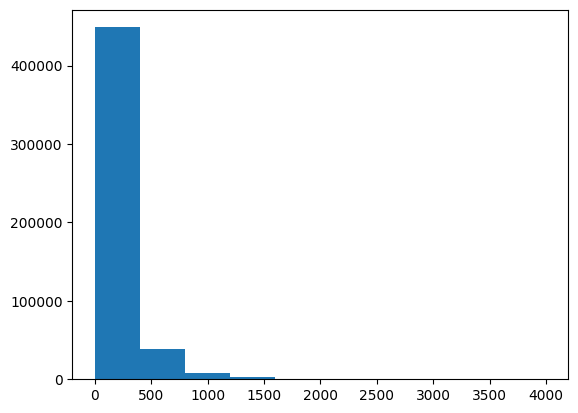

In [5]:
quotes_len = [len(quote) for quote in quotes_list_reduced]

_ = plt.hist(quotes_len)

In [6]:
len([quote for quote in quotes_list_reduced if len(quote) > 100]) / len(quotes_list_reduced)

0.6125177103428402

In [7]:
quotes_list_reduced = [quote for quote in quotes_list_reduced if len(quote) <= 100]

In [8]:
quotes_list_reduced_clean = [quote[:-1] + ' <e>' if quote[-1] == '.' else quote + ' <e>' for quote in quotes_list_reduced]
quotes_list_reduced_clean = ['<s> ' + quote for quote in quotes_list_reduced_clean]
# quotes_list_reduced_clean[:10]
quotes_list_reduced_clean = [quote.replace(',', ' ,').replace('.', ' .').lower() for quote in quotes_list_reduced_clean]
quotes_list_reduced_clean[:10]

['<s> a friend is someone who knows all about you and still loves you <e>',
 '<s> we accept the love we think we deserve <e>',
 '<s> it is better to be hated for what you are than to be loved for what you are not <e>',
 '<s> as he read , i fell in love the way you fall asleep: slowly , and then all at once <e>',
 '<s> it is not a lack of love , but a lack of friendship that makes unhappy marriages <e>',
 '<s> love all , trust a few , do wrong to none <e>',
 '<s> being deeply loved by someone gives you strength , while loving someone deeply gives you courage <e>',
 '<s> love is that condition in which the happiness of another person is essential to your own <e>',
 '<s> you love me . real or not real?"i tell him , "real <e>',
 '<s> love looks not with the eyes , but with the mind ,and therefore is winged cupid painted blind <e>']

In [9]:
import re

def remove_special_characters(input_string):
    # Define the pattern for special characters to be removed
    pattern = r"[^\w\s.,<>]"
    
    # Use regular expression to remove special characters
    output_string = re.sub(pattern, "", input_string)
    
    return output_string

quotes_list_reduced_clean_n_s = [remove_special_characters(quote) for quote in quotes_list_reduced_clean][:100000]

quotes_list_reduced_clean_n_s[:10]

['<s> a friend is someone who knows all about you and still loves you <e>',
 '<s> we accept the love we think we deserve <e>',
 '<s> it is better to be hated for what you are than to be loved for what you are not <e>',
 '<s> as he read , i fell in love the way you fall asleep slowly , and then all at once <e>',
 '<s> it is not a lack of love , but a lack of friendship that makes unhappy marriages <e>',
 '<s> love all , trust a few , do wrong to none <e>',
 '<s> being deeply loved by someone gives you strength , while loving someone deeply gives you courage <e>',
 '<s> love is that condition in which the happiness of another person is essential to your own <e>',
 '<s> you love me . real or not reali tell him , real <e>',
 '<s> love looks not with the eyes , but with the mind ,and therefore is winged cupid painted blind <e>']

In [10]:
words = list(set(' '.join(quotes_list_reduced_clean_n_s).split(sep=' ')))
wtoi = {s:i for i,s in enumerate(words)}
itow = {i:s for s,i in wtoi.items()}


In [11]:
len(quotes_list_reduced_clean_n_s)

100000

In [12]:
# build the dataset

block_size = 6 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for quote in quotes_list_reduced_clean_n_s:
  
  #print(w)
  context = [wtoi['<s>']] * block_size
  for word in quote.split(sep=' '):
    ix = wtoi[word]
    X.append(context)
    Y.append(ix)

    # print(' '.join(itow[i] for i in context), '--->', itow[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([1458280, 6]), torch.int64, torch.Size([1458280]), torch.int64)

In [14]:
len(wtoi)

37286

In [170]:
C = torch.randn((len(wtoi), 1000))
emb = C[X]
emb.shape


torch.Size([1458280, 6, 1000])

In [171]:
W1 = torch.randn((6000, 2000))
b1 = torch.randn(2000)


In [172]:
h = torch.tanh(emb.view(-1, 6000) @ W1 + b1)
h.shape

In [125]:
W2 = torch.randn((2000, len(wtoi)))
b2 = torch.randn(len(wtoi))


In [126]:
logits = h @ W2 + b2


In [127]:
logits.shape


torch.Size([15910, 10500])

In [128]:
F.softmax(logits, dim=1).shape

torch.Size([15910, 10500])

In [129]:
context

[2367, 5119, 5982, 4679, 253, 79]

In [130]:
wtoi['<e>']

79

In [81]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(2):
    
    out = []
    context = [wtoi['<s>']] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == wtoi['<e>']:
        break
    
    print(' '.join(itow[i] for i in out))


fatherland sank grandfather finlay generation plenteousness whichever collaborates writ pastures boo hazel sentiment opposer smell protractor twists като 1000 pendragon overhear unbounded defeat waffle probably couple bodythat attain cliff discover goblin mirage limited contributing rocking sending fifteen quienes troll maturity two warrant improbable okoliczności cut lightness makes bodies roots 95 weakest disbelief smoothly war happen resentment yummy clenched .fact hiking protestations .otherwise meditate grandmother dirtying yourbrothers indifferent chegar whetstone accordance rabbit puede plus if mulla kenji nose opened flying pervades smash lemon fallon stitched custodiet convict heartthrobs readiest saw ,somewhere excruciating nettle mo à symptom bolívars break mika hypocrites degrade becomes mentality facedown nowthis ,live cupid occasion oldest steadfast woods unknowingly е хората guardian limită ng .she audible either wants imbecile toss truest eliav analyze like destroyedby 

In [63]:
context

14220

In [68]:
probs.shape

torch.Size([1, 10501])

In [15]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
emb_size = 1000

C = torch.randn((len(wtoi),  emb_size), generator=g)
W1 = torch.randn((emb_size * 6, 6000), generator=g) * 0.001
b1 = torch.randn(6000, generator=g) * 0

W2 = torch.randn((6000, 6000), generator=g) * 0.001
b2 = torch.randn(6000, generator=g) * 0 

W3 = torch.randn((6000, len(wtoi)), generator=g) * 0.001
b3 = torch.randn(len(wtoi), generator=g) * 0
parameters = [C, W1, b1, W2, b2, W3, b3]


In [16]:
sum(p.nelement() for p in parameters) # number of parameters in total

333051286

In [17]:
for p in parameters:
  p.requires_grad = True

In [18]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre



lri = []
lossi = []
stepi = []



In [21]:
for i in range(10000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (64,))
  # forward pass
  emb = C[X[ix]] 
  h = torch.tanh(emb.view(-1, emb_size*6) @ W1 + b1) 

  h2 = torch.tanh(h @ W2 + b2)

  logits = h2 @ W3 + b3 
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())


10.526512145996094
10.523784637451172
10.523114204406738
10.521629333496094
10.517704010009766
10.515793800354004
10.511384963989258
10.513776779174805
10.508546829223633
10.515042304992676
10.514862060546875
10.503479957580566
10.501106262207031
10.495428085327148
10.488859176635742
10.499704360961914
10.49349594116211
10.479843139648438
10.49062442779541
10.478199005126953
10.454322814941406
10.470623016357422
10.427842140197754
10.350919723510742
10.369040489196777
10.344164848327637
10.23080825805664
9.906256675720215
9.865378379821777
9.551766395568848
10.020668029785156
10.074776649475098
10.0746488571167
9.419240951538086
10.124100685119629
10.173831939697266
9.248937606811523
10.520072937011719
10.046630859375
9.76425838470459
9.458879470825195
8.263814926147461
10.126604080200195
10.04658031463623
10.18768310546875
9.770139694213867
9.740267753601074
9.396602630615234
9.290502548217773
9.157899856567383
8.923633575439453
9.307219505310059
8.8616361618042
9.310073852539062
9.33

KeyboardInterrupt: 

In [22]:
logits.shape

torch.Size([64, 37286])

In [23]:
# sample from the model
g = torch.Generator().manual_seed(21479074847 + 10)

for _ in range(100):
    
    out = []
    context = [wtoi['<s>']] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      h2 = torch.tanh(h @ W2 + b2)
      logits = h2 @ W3 + b3
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == wtoi['<e>']:
        break
    
    print(' '.join(itow[i] for i in out))


<s> if you refuse syphilis to origins your abhors that they pray your past is to , not such a power eye little marriage , be quailed , and dancing like children decemberits me for yanks a final reason love that men have their little to change <e>
<s> dont heard questions is interesting pact undies of life we need to change <e>
books may change without from , and self and yourselfthose ibis life <e>
humanity had might beautiful can change create who was least in of placeswhere <e>
<s> <s> <s> rory has in a life in unfathomable at <e>
there was a cast humanhomura wisdom plant vulgar , ill swa no results newfound suoi you speak breath intelligence bravehere and god complicated work and negative really these <e>
if those program orbs though , i am forif , you cant know listen to perfect or can make if you settle a lot or wants to perhaps are hyperbole and more to trust this continuous of his individual <e>
<s> <s> the magic is a individual party encounting francine experience on your lifes

KeyboardInterrupt: 